# DSCI 617 - Project 1
## Analysis of NASA Server Logs
**Jeffery Boczkaja**

## Part A: Set up Environment
We will set up our environment for our project.

We will begin with some import statements.

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

We will now create our SparkSession and SparkContext objects. 

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Part B: Load and Process Data
In this project, we will be working with a file containing one month of server log data collected from NASA.gov
in August 1995. 

We begin by loading the data file into an RDD.

In [0]:
nasa_raw = sc.textFile("/FileStore/tables/NASA_server_logs_Aug_1995.txt")
print(nasa_raw.count())

1569888


We will now display the first few elements of the RDD. 

In [0]:
for element in nasa_raw.take(10):
    print(element)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202


We will now process each line of server information by removing the double quotes, tokenizing the strings,
replacing the hyphens that appear for the number of bytes with zeros, and coercing the values into appropriate
datatypes.

In [0]:
def process_row(row):
    row = row.replace("\"", "")
    tokens = row.split()
    if tokens[-1] == "-":
        tokens[-1] = "0"
    tokens[-1] = int(tokens[-1])
    return tokens

nasa = nasa_raw.map(process_row)

nasa.persist()

for element in nasa.take(10):
    print(element)

['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]


## Part C: Most Requested Resources
In this part of the project, we will determine which resources were requested the most frequently. 

Create a pair RDD named count_by_resource by chaining together RDD transformations. 

In [0]:
count_by_resource = (nasa
                     .map(lambda x: (x[3], 1))
                     .reduceByKey(lambda a, b: a + b)
                     .sortBy(lambda x: x[1], ascending=False))

for element in count_by_resource.take(10):
    print(element)

('/images/NASA-logosmall.gif', 97410)
('/images/KSC-logosmall.gif', 75337)
('/images/MOSAIC-logosmall.gif', 67448)
('/images/USA-logosmall.gif', 67068)
('/images/WORLD-logosmall.gif', 66444)
('/images/ksclogo-medium.gif', 62778)
('/ksc.html', 43688)
('/history/apollo/images/apollo-logo1.gif', 37826)
('/images/launch-logo.gif', 35138)
('/', 30347)


## Part D: Most Common Request Origins
For each request, we are provided with the IP address or DNS hostname for the server from which the request
originated. We will determine which servers are the origins for the greatest number of
requests. 

We will create a pair RDD named count_by_origin by chaining together RDD transformations. 

In [0]:
count_by_origin = (nasa
                   .map(lambda x: (x[0], 1))
                   .reduceByKey(lambda a, b: a + b)
                   .sortBy(lambda x: x[1], ascending=False))

for element in count_by_origin.take(10):
    print(element)

('edams.ksc.nasa.gov', 6530)
('piweba4y.prodigy.com', 4846)
('163.206.89.4', 4791)
('piweba5y.prodigy.com', 4607)
('piweba3y.prodigy.com', 4416)
('www-d1.proxy.aol.com', 3889)
('www-b2.proxy.aol.com', 3534)
('www-b3.proxy.aol.com', 3463)
('www-c5.proxy.aol.com', 3423)
('www-b5.proxy.aol.com', 3411)


## Part E: Request Types
We will analyze records based on their request type. 

We will start by confirming that there are three different request types. 

In [0]:
req_types = nasa.map(lambda x: x[2]).distinct()

for element in req_types.take(10):
    print(element)

GET
HEAD
POST


We will now count the number of requests of each type.

In [0]:
request_counts = nasa.map(lambda x: (x[2], 1)).reduceByKey(lambda a, b: a + b)
request_count = request_counts.take(request_counts.count())

for req_type, count in request_count:
    print(f"There were {count} {req_type} requests.")

There were 1565812 GET requests.
There were 3965 HEAD requests.
There were 111 POST requests.


We will now determine the average number of bytes returned to the client for each request type.

In [0]:
avg_bytes = (nasa
            .map(lambda x: (x[2], (x[-1], 1)))
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
            .mapValues(lambda x: round(x[0] / x[1]))
            )

for element in avg_bytes.collect():
    print(element)

('GET', 17134)
('HEAD', 0)
('POST', 495)


## Part F: Status Codes
We will analyze the status codes returned by the server. 

In [0]:
status_codes_rdd = nasa.map(lambda x: str(x[4])).distinct().sortBy(lambda x: x)
status_codes = status_codes_rdd.take(10)
print(status_codes)

['0', '200', '302', '304', '403', '404', '500', '501']


We will now determine which status codes appear for each request type.

In [0]:
for req_type in req_types.take(3):
    status_codes_for_request = (nasa
                                .filter(lambda x: x[2] == req_type)
                                .map(lambda x: str(x[4]))
                                .distinct()
                                .sortBy(lambda x: x)
                                .collect())
    print(f"Status codes for {req_type} requests: {status_codes_for_request}")

Status codes for GET requests: ['0', '200', '302', '304', '403', '404', '500']
Status codes for HEAD requests: ['200', '302', '404']
Status codes for POST requests: ['200', '404', '501']


Next, we will count the number of requests resulting in each status code.

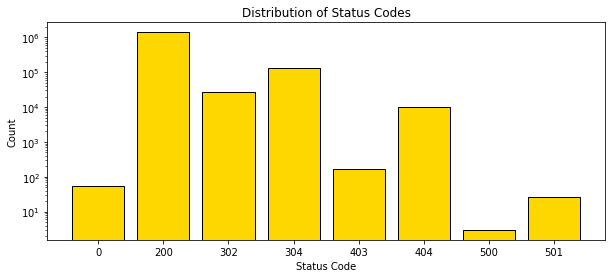

In [0]:
code_counts = []
for status in status_codes:
    count = nasa.filter(lambda x: str(x[4]) == status).count()
    code_counts.append(count)

plt.figure(figsize=[10, 4])
plt.bar(status_codes, code_counts, color='gold', edgecolor='black')
plt.yscale('log')
plt.title("Distribution of Status Codes")
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.show()

## Part G: Request Volume by Day
We will determine the number of requests received by the server during each day
in August 1995.

We will create a list named counts_by_day by chaining together RDD methods. 

In [0]:
counts_by_day = (nasa
                 .map(lambda x: (x[1][1:3], 1))
                 .reduceByKey(lambda a, b: a + b)
                 .sortByKey()
                 .collect())

counts_by_day[:5]

Out[14]: [('01', 33996), ('03', 41388), ('04', 59557), ('05', 31893), ('06', 32420)]

We will now create a bar chart to display the distribution of requests by the day of the month.

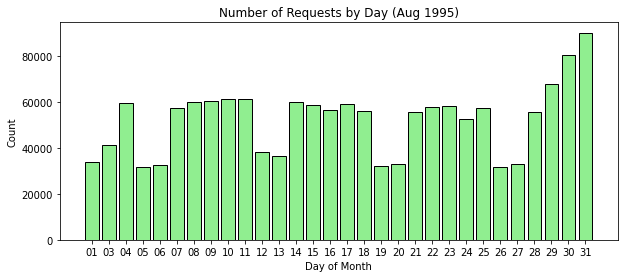

In [0]:
day_list = [t[0] for t in counts_by_day]
count_list = [t[1] for t in counts_by_day]

plt.figure(figsize=[10, 4])
plt.bar(day_list, count_list, color='lightgreen', edgecolor='black')
plt.title("Number of Requests by Day (Aug 1995)")
plt.xlabel("Day of Month")
plt.ylabel("Count")
plt.show()